In [1]:
# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from keras.datasets import mnist

# Keras modules
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

# Load Dataset

In [2]:
#normal_dataset_dir = 'normal/normal'
#normal_images = os.listdir(normal_dataset_dir)
pneumonia_dataset_dir = 'pneumonia/pneumonia'
pneumonia_images = os.listdir(pneumonia_dataset_dir)

def get_data(data_path):
    x=[]
    for filename in data_path:
        #img = img_to_array(load_img(normal_dataset_dir + "/" + filename, target_size=(28,28,3)))
        img = img_to_array(load_img(pneumonia_dataset_dir + "/" + filename, target_size=(28,28,3)))
        x.append(img)
    x = np.array(x).astype('float32')
    x = (x - 127.5) / 127.5
    return x

#normal_dataset = get_data(normal_images)
pneumonia_dataset = get_data(pneumonia_images)

# Define DCGAN 

In [3]:
class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.history = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense((128*7*7), activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((7,7,128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation('tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        #X_train = normal_dataset
        X_train = pneumonia_dataset

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, D acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            
            self.history.append({"D": d_loss[0], "G": g_loss})
    
    def _predict_noise(self, size):
        noise = np.random.normal(0, 1, (size, self.latent_dim))
        return self.generator.predict(noise)
        
    def gen(self, size):
        generated = self._predict_noise(size)
        generated = 0.5 * generated + 0.5
        return generated

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("output/%d_pneumonia.png" % epoch)
        plt.close()
    
    def plot_loss(self):
        hist = pd.DataFrame(self.history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()

In [6]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=10000, batch_size=32, sample_interval=500)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

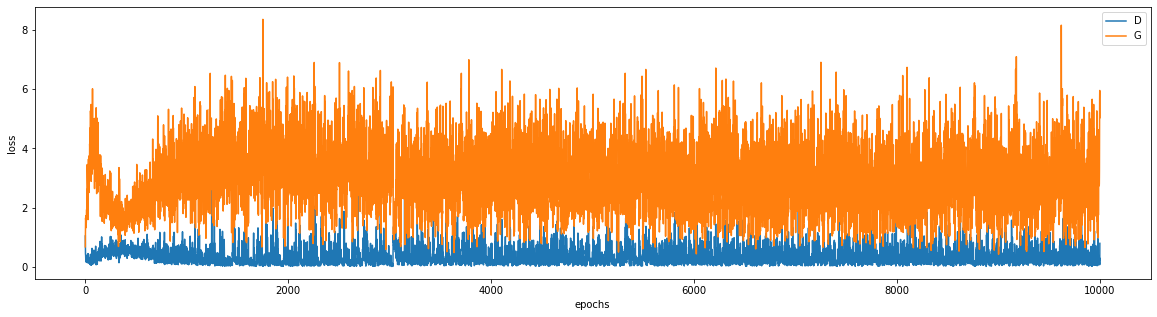

In [7]:
dcgan.plot_loss()

In [8]:
#get normal gan images
#gan_images = dcgan.gen(1583)
#get pneumonia gan images
gan_images = dcgan.gen(4273)

for i in range(len(gan_images)):
    #save_img("output/gan_normal/{}.png".format(i), gan_images[i])
    save_img("output/gan_pneumonia/{}.png".format(i+3000), gan_images[i])